In [1]:
# Importation librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

<img src='./images/logo-FAO-sans-fond.png' width=400px />

# Réalisez une étude de santé publique avec Python

Dans ce projet, nous intervenons en tant que *Data Analyst* au sein d'une équipe de chercheurs de la *Food and Agriculture Organization of the United Nations (FAO)* qui est une agence spécialisée de l'ONU menant des efforts internationaux vers l'élimination de la faim. L'objectif est de réaliser une étude sur le thème de la sous-nutrition.

<a id="0"></a> 
## Table des matières

* [Mise en place des *DataFrame*](#1)
    * [*DataFrame* de l'aide alimentaire](#2)
    * [*DataFrame* de la disponibilité alimentaire](#3)
    * [*DataFrame* de la population](#4)
    * [*DataFrame* de la sous-nutrition](#5)
* [Recherches de Julien](#6)
    * [Lien logique entre les variables de la disponibilité alimentaire](#7)
    * [Utilisation des céréales](#8)
    * [Analyse de l'exportation par rapport à la production](#9)
* [Informations demandées par Marc](#10)
    * [Proportion de personnes en état de sous-nutrition](#11)
    * [Nombre théorique de personnes qui pourraient être nourries](#12)
    * [Nombre théorique de personnes qui pourraient être nourries avec les produits végétaux](#13)
    * [Nombre théorique de personnes qui pourraient être nourries avec les produits animals](#14)
    * [Utilisation de la disponibilité intérieure](#15)
* [Demandes de Mélanie](#16)
    * [Pays avec la plus forte proportion de personnes sous-alimentées](#17)
    * [Pays ayant le plus bénéficié d'aides depuis 2013](#18)
    * [Pays avec le plus et le moins de disponibilité par habitant](#19)
* [Conclusion](#20)

<a id="1"></a> 
## Mise en place des *DataFrame*

Dans cette première partie, nous allons importer, préparer et la vérifier les données qui vont composer les *DataFrame* que nous allons utiliser pour répondre aux demandes formulées dans le cadre de l'étude de santé.<br>
Quatre fichiers csv ayant été générés grâce à la base de données [FAOSTAT](https://www.fao.org/faostat/fr/#home) sont à notre disposition.<br>

Pour chaque fichier, nous allons:
* importer les données grâce à la librairie Pandas et à sa méthode `read_csv`;
* vérifier l'importation et afficher les premières informations;
* nettoyer les *DataFrame* (suppression de colonnes inutiles, harmonisation des noms de colonne poour faciliter les futures manipulations, etc.. );
* afficher les premières informations sur les données.

**Note:**<br>
L'étude concerne en grande partie l'année 2017, il faudra donc d'abord **générer un nouveau fichier csv depuis FAOSTAT et non pas utiliser celui fourni à l'origine**.<br>

<a id="2"></a> 
### *DataFrame* de l'aide alimentaire

In [2]:
# Importation 'aide_alimentaire.csv'
aide = pd.read_csv('./datasets/aide-alimentaire.csv', sep = ',')

aide.head(3)

,Pays bénéficiaire,Année,Produit,Valeur
0,Afghanistan,2013,Autres non-céréales,682
1,Afghanistan,2014,Autres non-céréales,335
2,Afghanistan,2013,Blé et Farin,39224


In [3]:
# Affichage dimensions DataFrame
aide.shape

(1475, 4)

In [4]:
# Affichage type données
aide.dtypes

Pays bénéficiaire    object
Année                 int64
Produit              object
Valeur                int64
dtype: object

Commentaires:
* les données sont correctement importées et correspondent à celles du fichier d'origine;
* la taille du jeu de données est identique au fichier source;
* les accents et majuscules vont être supprimés des noms de colonnes et « Pays Bénéficiaire » va être renommée pour correspondre aux autres *DataFrame*;
* étant une donnée qualitive, l'année sera convertie en objet.

In [5]:
# Renommage et formatage noms colonnes
aide = (aide
    .rename(columns = {'Pays bénéficiaire':'zone', 'Année':'annee'})
    .rename(str.lower, axis = 'columns')
)

#Conversion type
aide['annee'] = aide['annee'].astype(object)

aide.head(3)

,zone,annee,produit,valeur
0,Afghanistan,2013,Autres non-céréales,682
1,Afghanistan,2014,Autres non-céréales,335
2,Afghanistan,2013,Blé et Farin,39224


In [6]:
# Vérification présence valeurs NA
aide.isna().any()

zone       False
annee      False
produit    False
valeur     False
dtype: bool

Il n'y a pas de valeurs manquantes dans le jeu de données.

<a id="3"></a> 
### *DataFrame* de la disponibilité alimentaire

In [7]:
# Importation 'dispo_alimentaire_2017.csv'
disponibilite = pd.read_csv('./datasets/dispo-alimentaire-2017.csv', sep = ';')

disponibilite.head(3)

,Domaine,Zone,Élément,Produit,Origine,Année,Valeur
0,Bilans Alimentaires (2010-),Afghanistan,Production,Blé et produits,vegetale,2017,4281.0
1,Bilans Alimentaires (2010-),Afghanistan,Importations - Quantité,Blé et produits,vegetale,2017,3080.0
2,Bilans Alimentaires (2010-),Afghanistan,Variation de stock,Blé et produits,vegetale,2017,208.0


In [8]:
# Affichage dimensions DataFrame
disponibilite.shape

(283710, 7)

In [9]:
# Affichage type données
disponibilite.dtypes

Domaine     object
Zone        object
Élément     object
Produit     object
Origine     object
Année        int64
Valeur     float64
dtype: object

In [10]:
# Vérification présence valeurs NA
disponibilite.isna().any()

Domaine    False
Zone       False
Élément    False
Produit    False
Origine    False
Année      False
Valeur      True
dtype: bool

In [11]:
# Affichage taux valeurs NA de 'Valeur'
disponibilite['Valeur'].isna().mean()

0.4061576962391174

Commentaires:
* les données sont correctement importées et correspondent à celles du fichier d'origine;
* la taille du jeu de données est identique au fichier source;
* les colonnes « Domaine » et « Année » sont inutiles et vont être supprimées;
* la colonne « Élément » va être pivotée pour pouvoir faciliter la suite de l'étude;
* les accents et majuscules des entêtes de colonnes vont également être supprimés.

In [12]:
# Mise en forme DataFrame avec pivotage colonne 'Élément'
disponibilite = (disponibilite
    .drop(['Domaine','Année'], axis = 1)
    .pivot_table(index = ['Zone','Produit','Origine'], columns = 'Élément', values = 'Valeur', fill_value = 0)
    .reset_index() # Transformation tableau pivoté en DataFrame
    .rename_axis(None, axis = 1)
)

# Formatage noms colonnes
disponibilite.columns = (disponibilite.columns
    .str.lower()
    .str.replace('[é,è]', 'e', regex = True)
)

disponibilite.head(3)

,zone,produit,origine,aliments pour animaux,autres utilisations (non alimentaire),disponibilite alimentaire (kcal/personne/jour),disponibilite alimentaire en quantite (kg/personne/an),disponibilite de matiere grasse en quantite (g/personne/jour),disponibilite de proteines en quantite (g/personne/jour),disponibilite interieure,exportations - quantite,importations - quantite,nourriture,pertes,production,semences,traitement,variation de stock
0,Afghanistan,Abats Comestible,animale,0.0,0.0,4,1.42,0.18,0.62,55.0,0.0,6.0,51.0,4,49.0,0.0,0,0.0
1,Afghanistan,"Agrumes, Autres",vegetale,0.0,0.0,1,1.35,0.01,0.02,51.0,0.0,33.0,49.0,2,18.0,0.0,0,0.0
2,Afghanistan,"Alcool, non Comestible",vegetale,0.0,0.0,0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0


Les noms de colonnes ne sont pas facilement exploitables car ils sont trop long, nous allons les renommer.

In [13]:
# Renommage colonnes
disponibilite = disponibilite.rename(
    columns = {
        'aliments pour animaux':'aliments_animaux', 'autres utilisations (non alimentaire)':'autres_utilisations',
        'disponibilite alimentaire (kcal/personne/jour)':'disponibilite_kcal_p_j',
        'disponibilite alimentaire en quantite (kg/personne/an)':'disponibilite_kg_p_an',
        'disponibilite de matiere grasse en quantite (g/personne/jour)':'disponibilite_MG_g_p_j',
        'disponibilite de proteines en quantite (g/personne/jour)':'disponibilite_proteines_g_p_j',
        'disponibilite interieure':'disponibilite_interieure', 'exportations - quantite':'exportations',
        'importations - quantite':'importations', 'variation de stock':'variation_stock'
    }
)

disponibilite.head(3)

,zone,produit,origine,aliments_animaux,autres_utilisations,disponibilite_kcal_p_j,disponibilite_kg_p_an,disponibilite_MG_g_p_j,disponibilite_proteines_g_p_j,disponibilite_interieure,exportations,importations,nourriture,pertes,production,semences,traitement,variation_stock
0,Afghanistan,Abats Comestible,animale,0.0,0.0,4,1.42,0.18,0.62,55.0,0.0,6.0,51.0,4,49.0,0.0,0,0.0
1,Afghanistan,"Agrumes, Autres",vegetale,0.0,0.0,1,1.35,0.01,0.02,51.0,0.0,33.0,49.0,2,18.0,0.0,0,0.0
2,Afghanistan,"Alcool, non Comestible",vegetale,0.0,0.0,0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0


<a id="4"></a> 
### *DataFrame* de la population

In [14]:
# Importation 'population.csv'
population = pd.read_csv('./datasets/population.csv', sep = ',')

population.head(3)

,Zone,Année,Valeur
0,Afghanistan,2013,32269.589
1,Afghanistan,2014,33370.794
2,Afghanistan,2015,34413.603


In [15]:
# Affichage dimensions DataFrame
population.shape

(1416, 3)

In [16]:
# Affichage type données
population.dtypes

Zone       object
Année       int64
Valeur    float64
dtype: object

Commentaires:
* les données sont correctement importées et correspondent à celles du fichier d'origine;
* la taille du jeu de données est identique au fichier source;
* les accents et majuscules vont être supprimés des noms de colonnes;
* étant une donnée qualitive, l'année sera convertie en objet.

In [17]:
# Renommage et formatage noms colonnes
population = (population
    .rename(str.lower, axis = 'columns')
    .rename(columns = {'année':'annee'})
)

# Conversion type
population['annee'] = population['annee'].astype(object)

population.head(3)

,zone,annee,valeur
0,Afghanistan,2013,32269.589
1,Afghanistan,2014,33370.794
2,Afghanistan,2015,34413.603


In [18]:
# Vérification présence valeurs NA
population.isna().any()

zone      False
annee     False
valeur    False
dtype: bool

Il n'y a pas de valeurs manquantes dans le jeu de données.

<a id="5"></a> 
### *DataFrame* de la sous-nutrition

In [19]:
# Importation 'sous_nutrition.csv'
sous_nutrition = pd.read_csv('./datasets/sous-nutrition.csv', sep = ',')

sous_nutrition.head(3)

,Zone,Année,Valeur
0,Afghanistan,2012-2014,8.6
1,Afghanistan,2013-2015,8.8
2,Afghanistan,2014-2016,8.9


In [20]:
# Affichage dimensions DataFrame
sous_nutrition.shape

(1218, 3)

In [21]:
# Affichage type données
sous_nutrition.dtypes

Zone      object
Année     object
Valeur    object
dtype: object

Commentaires:
* les données sont correctement importées et correspondent à celles du fichier d'origine;
* la taille du jeu de données est identique au fichier source;
* les accents et majuscules vont être supprimés des noms de colonnes;
* « Année » est ici un intervalle d'années que l'on va remplacer par la valeur intermédiaire de la plage;
* « Valeur » est une donnée quantitive et sera convertie en valeur numérique.

In [22]:
# Renommage et formatage noms colonnes
sous_nutrition = (sous_nutrition
    .rename(str.lower, axis = 'columns')
    .rename(columns = {'année':'annee'})
)

# Calcul année intermédiaire
sous_nutrition[['debut', 'fin']] = sous_nutrition['annee'].str.split('-', n = 1, expand = True).apply(pd.to_numeric)
sous_nutrition['annee'] = sous_nutrition[['debut','fin']].mean(axis = 1).astype(int).astype(object)
sous_nutrition = sous_nutrition.drop(['debut','fin'],axis = 1)

sous_nutrition.head(3)

,zone,annee,valeur
0,Afghanistan,2013,8.6
1,Afghanistan,2014,8.8
2,Afghanistan,2015,8.9


In [23]:
# Conversion type
try:
    sous_nutrition['valeur'] = pd.to_numeric(sous_nutrition['valeur'])
except ValueError as erreur:
    print(erreur)

Unable to parse string "<0.1" at position 60


La conversion a échoué car des lignes contiennent la chaîne de caractères « <0.1 ». Si ces lignes ont été annotées de cette manière, on peut considérer que c'est parce qu'elles ont des valeurs suffisament faibles pour ne pas être précisées. Nous allons donc les remplacer par « 0 » avant de faire la conversion.

In [24]:
# Remplacement valeurs '<0.1' par '0' et conversion type
sous_nutrition['valeur'] = sous_nutrition['valeur'].replace(regex = '<0.1', value = 0)
sous_nutrition['valeur'] = pd.to_numeric(sous_nutrition['valeur'])

# Vérification présence valeurs NA
sous_nutrition.isna().any()

zone      False
annee     False
valeur     True
dtype: bool

In [25]:
# Affichage taux valeurs NA de 'valeur'
sous_nutrition['valeur'].isna().mean()

0.4876847290640394

Près de la moitié des valeurs de la colonne  « valeur » sont manquantes. Voyons quels pays sont concernés.

In [26]:
# Affiche aperçu 'zone' ayant valeur 'sous_nutrition' manquante
sous_nutrition.loc[sous_nutrition['valeur'].isna()].groupby('zone')['valeur'].mean().index

Index(['Allemagne', 'Andorre', 'Antigua-et-Barbuda', 'Argentine', 'Australie',
       'Autriche', 'Azerbaïdjan', 'Bahamas', 'Bahreïn', 'Belgique',
       ...
       'Tuvalu', 'Ukraine', 'Uruguay', 'Yémen', 'Zambie', 'Zimbabwe',
       'Érythrée', 'États-Unis d'Amérique', 'Îles Cook', 'Îles Marshall'],
      dtype='object', name='zone', length=101)

Il y a des informations manquantes aussi bien pour des pays réellement concernés (ex. Zimbabwe) que pour des pays qui ne le sont pas (ex. Belgique). On peut dans tous les cas s'interroger sur la fiablité de certains résultats que nous allons trouver dans la suite de l'étude.

In [27]:
# Vérification type données
sous_nutrition.dtypes

zone       object
annee      object
valeur    float64
dtype: object

<a id="6"></a> 
## Recherches de Julien

Les *DataFrame* sont maintenant exploitables. Nous allons poursuivre le travail de notre prédécessuer, Julien, à partir des notes qu'il nous a laissé.

<a id="7"></a> 
### Lien logique entre les variables de la disponibilité alimentaire

Le *DataFrame* `disponibilite`, comprend les colonnes ci-dessous.

In [28]:
# Affichage nom colonnes
disponibilite.columns

Index(['zone', 'produit', 'origine', 'aliments_animaux', 'autres_utilisations',
       'disponibilite_kcal_p_j', 'disponibilite_kg_p_an',
       'disponibilite_MG_g_p_j', 'disponibilite_proteines_g_p_j',
       'disponibilite_interieure', 'exportations', 'importations',
       'nourriture', 'pertes', 'production', 'semences', 'traitement',
       'variation_stock'],
      dtype='object')

La division de la statistique FAO donne la définition suivante:<br>
« Production + importations - exportations + évolution des stocks (augmentation ou diminution) = disponibilités servant à une utilisation intérieure ».<br><br>
En reprenant les noms des colonnes de notre jeu de données, cela donne:<br><br>
$(production + importations - exportations + variation\_ stock) = disponibilite\_ interieure = (aliments\_ animaux + autres\_ utilisations + nourriture + pertes + semences + traitement)$

<a id="8"></a> 
### Utilisation des céréales

L'objectif est de comparer l'utilisation des céréales, notamment la répartition entre la quantité destinée à l'alimentation humaine et celle destinée à l'alimentation des animaux.<br>
A partir du *DataFrame* `disponibilite`, nous allons extraire la somme de la quantité de céréales des colonnes « nourriture » et « aliments_animaux ».

In [29]:
# Création liste céréales (source: FAOSTAT)
liste_cereales = [
    'Avoine', 'Blé et produits', 'Céréales, Autres', 'Maïs et produits', 'Millet et produits',
    'Orge et produits', 'Riz et produits', 'Seigle et produits', 'Sorgho et produits'
]

# Création DataFrame 'utilisation_cereales' depuis 'liste_cereales'
utilisation_cereales = disponibilite.loc[disponibilite['produit'].isin(liste_cereales), ['nourriture', 'aliments_animaux']]

# Affichage somme céréales pour 'nourriture' et 'aliments_animaux'
utilisation_cereales.sum()

nourriture          1602845.0
aliments_animaux    1159399.0
dtype: float64

La quantité de céréales utilisés pour les animaux est inférieure à celle utilisée pour l'alimentation humaine mais, en comparaison avec cette dernière, sa valeur reste très importante.<br>
Afin de mieux nous rendre compte de la répartition, nous pouvons afficher ces résultats sous forme graphique.

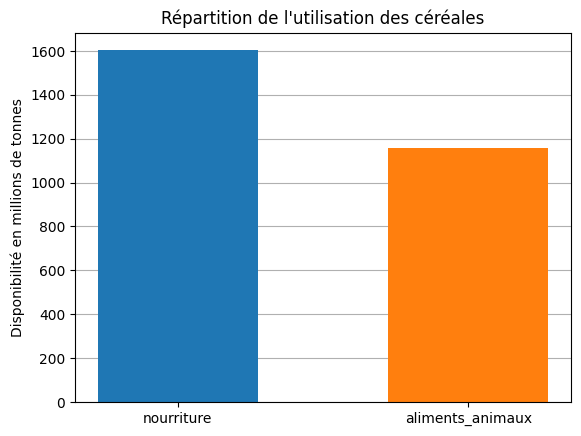

In [30]:
# Traçage graphique
taille_barres = (utilisation_cereales.sum() / 1000)
nom_barres = utilisation_cereales.columns
position_barres = np.arange(len(taille_barres))

plt.bar(position_barres, taille_barres, width = 0.55, color = ['tab:blue', 'tab:orange'], zorder = 2)
plt.grid(axis = 'y')
plt.xticks(position_barres, nom_barres)
plt.ylabel('Disponibilité en millions de tonnes')
plt.title('Répartition de l\'utilisation des céréales')
plt.show()

<a id="9"></a> 
### Analyse de l'exportation par rapport à la production

Penchons nous sur la relation entre la production, l'exportation et la sous-nutrition en reprenant l'exemple de Julien sur la Thaïlande et de son utilisation du manioc.

In [31]:
# Création DataFrame 'exportation_production' et affichage informations en Thaïlande pour manioc
exportation_production = disponibilite[['zone','origine', 'produit', 'exportations', 'production', 'nourriture']].copy()
exportation_production.loc[(exportation_production['zone'] == 'Thaïlande') & (exportation_production['produit'].str.contains('manioc', case = False))]

,zone,origine,produit,exportations,production,nourriture
14958,Thaïlande,vegetale,Manioc et produits,29409.0,30495.0,153.0


Puis, calculons le taux de sous-nutrition.

In [32]:
# Création et calcul variable 'taux_sous_nutrition_thailande'
sous_nutrition_thailande = (sous_nutrition.loc[(sous_nutrition['zone'] == 'Thaïlande') & (sous_nutrition['annee'] == 2017), ['valeur']]).squeeze()

population_thailande = (population.loc[(population['zone'] == 'Thaïlande') & (population['annee'] == 2017), ['valeur']] / 1000).squeeze()

taux_sous_nutrition_thailande = (sous_nutrition_thailande / population_thailande)
print('{:.2%}'.format(taux_sous_nutrition_thailande))

8.96%


La Thaïlande a un taux de sous-nutrition assez important (proche de 9 % en 2017). Néanmoins, on s'aperçoit que pratiquement la totalité de sa production de manioc est exportée et que la part restante pour l'alimentation humaine est proche de 0.

<a id="10"></a> 
## Informations demandées par Marc

Le responsable de l'équipe que nous venons d'intégrer a formulé plusieurs demandes auxquelles nous allons répondre.


<a id="11"></a> 
### Proportion de personnes en état de sous-nutrition

Le but est de calculer le taux de sous-nutrition au niveau mondial en 2017. A l'aide d'une jointure, nous allons créer un nouveau *DataFrame* à partir de celui de la population et de celui de la nutrition. Avant de réaliser cette opération, faisons quelques vérifications sur les données présentes dans les deux jeux de données.

In [33]:
# Affiche années des Dataframe 'population' et 'sous_nutrition'
print(population.annee.unique(), sous_nutrition.annee.unique(), sep = '\n')

[2013 2014 2015 2016 2017 2018]
[2013 2014 2015 2016 2017 2018]


Les données présentes dans les deux *DataFrame* couvrent bien la même période de temps.

In [34]:
# Affichage nombre zones des Dataframe 'population' et 'sous_nutrition'
print (population['zone'].nunique(), sous_nutrition['zone'].nunique(), sep = '\n')

236
203


Le nombre de zones présentes dans le *DataFrame* de la population est supérieur à celui du *DataFrame*  de la sous-nutrition. Cela signifie que pour certaines zones, nous n'aurons pas d'information de sous-nutrition.

In [35]:
# Jointure DataFrame 'population' et 'sous_nutrition'
population_sous_nutrition = pd.merge(
    (population.loc[population['annee'] == 2017, :]), (sous_nutrition.loc[sous_nutrition['annee'] == 2017, :]),
    on = ['zone'], how = 'left'
)

population_sous_nutrition.head(3)

,zone,annee_x,valeur_x,annee_y,valeur_y
0,Afghanistan,2017,36296.113,2017,10.5
1,Afrique du Sud,2017,57009.756,2017,3.1
2,Albanie,2017,2884.169,2017,0.1


In [36]:
# Suppression et renommage colonnes
population_sous_nutrition = (population_sous_nutrition
    .drop(['annee_x', 'annee_y'], axis = 1)
    .rename(columns = {'valeur_x':'valeur_population', 'valeur_y':'valeur_sous_nutrition'})
)

# Conversion colonne 'valeur_population' en millions d'habitants
population_sous_nutrition['valeur_population'] = population_sous_nutrition['valeur_population'] / 1000

population_sous_nutrition.head(3)

,zone,valeur_population,valeur_sous_nutrition
0,Afghanistan,36.296113,10.5
1,Afrique du Sud,57.009756,3.1
2,Albanie,2.884169,0.1


Nous savons que l'information de sous-nutrition est manquante pour 33 des 236 zones de notre jeu données. Mais l'important est de savoir si les zones sans information représentent une part de population significative par rapport au total.

In [37]:
# Affichage population sans 'valeur_sous_nutrition' et population totale
print(
    '{:.2f}'.format (population_sous_nutrition.loc[population_sous_nutrition['valeur_sous_nutrition'].isna(),'valeur_population'].sum()),
    '{:.2f}'.format (population_sous_nutrition['valeur_population'].sum()),
    sep = '\n'
)

3365.30
7548.13


La population pour laquelle nous n'avons pas d'information est très importante par rapport à la population totale.<br>
Nous allons quand même calculer le taux de sous-nutrition en excluant les pays concernés tout en gardant en tête qu'il nous manque plus de 40 % des informations.

In [38]:
# Calcul et affichage variable 'taux_sous_nutrition'

taux_sous_nutrition =(
    population_sous_nutrition.loc[~population_sous_nutrition['valeur_sous_nutrition'].isna(),'valeur_sous_nutrition'].sum()
    / population_sous_nutrition.loc[~population_sous_nutrition['valeur_sous_nutrition'].isna(),'valeur_population'].sum()
)
print('{:.1%}'.format (taux_sous_nutrition))

12.8%


<a id="12"></a> 
### Nombre théorique de personnes qui pourraient être nourries

A partir des informations de disponibilité et plus spécialement des apports disponibles par personne (kcal/p/j), nous allons calculer la population qu'il serait possible de nourrir grâce à la disponibilité mondiale. Pour cela, nous allons d'abord rapprocher les *DataFrame* `disponibilite` et `population_nutrition`.

In [39]:
# Création DataFrame 'disponibilite_zone'
disponibilite_zone = (disponibilite
    .groupby(['zone'])[['aliments_animaux', 'autres_utilisations', 'disponibilite_kcal_p_j', 'disponibilite_kg_p_an',
       'disponibilite_MG_g_p_j', 'disponibilite_proteines_g_p_j', 'disponibilite_interieure', 'exportations',
       'importations', 'nourriture', 'pertes', 'production', 'semences', 'traitement', 'variation_stock']]
    .sum(numeric_only = True)
    .reset_index()
)

# Jointure DataFrame 'disponibilite_zone' et 'population_sous_nutrition'
disponibilite_zone = pd.merge((disponibilite_zone), (population_sous_nutrition), on = ['zone'], how = 'left')

# Affichage taux valeurs NA
disponibilite_zone.isna().mean()

zone                             0.000000
aliments_animaux                 0.000000
autres_utilisations              0.000000
disponibilite_kcal_p_j           0.000000
disponibilite_kg_p_an            0.000000
disponibilite_MG_g_p_j           0.000000
disponibilite_proteines_g_p_j    0.000000
disponibilite_interieure         0.000000
exportations                     0.000000
importations                     0.000000
nourriture                       0.000000
pertes                           0.000000
production                       0.000000
semences                         0.000000
traitement                       0.000000
variation_stock                  0.000000
valeur_population                0.005376
valeur_sous_nutrition            0.440860
dtype: float64

In [40]:
# Affichage pays sans valeur sous-nutrition
disponibilite_zone.loc[(disponibilite_zone['valeur_population'].isna()) & (disponibilite_zone['valeur_sous_nutrition'].isna()), 'zone']

34    Chine
Name: zone, dtype: object

In [41]:
# Recherche Chine dans Dataframe 
disponibilite_zone.loc[disponibilite_zone['zone'].str.contains('chine', case = False), ['zone', 'valeur_population']]

,zone,valeur_population
34,Chine,NaN
35,Chine - RAS de Hong-Kong,7.306322
36,Chine - RAS de Macao,0.622585
37,"Chine, Taiwan Province de",23.674546
38,"Chine, continentale",1421.021791


Suite à la jointure, on constate que la Chine est présente plusieurs fois dont une fois sans valeur de population. « Chine » et « Chine, continentale » correspondent à la même chose. Nous pouvons donc supprimer la ligne sans valeur.

In [42]:
# Suppression 'Chine'
disponibilite_zone = disponibilite_zone.drop(index = 34).reset_index(drop = True)

Nous pouvons à présent poursuivre notre étude. Pour cela nous choisissons de définir les apports calorifiques journaliers à **2 250 kcal/personne/jour**. Cela correspond aux besoins moyens d'un adulte.

In [43]:
# Calcul et affichage variable 'nombre_theorique_total'
besoins_kcal_j_p = 2250
nombre_theorique_total = (disponibilite_zone['disponibilite_kcal_p_j'] * disponibilite_zone['valeur_population']).sum() / besoins_kcal_j_p
print(
    '{:.1f}'.format(nombre_theorique_total),
    'pour',
    '{:.1f}'.format(population.loc[population['annee'] == 2017, 'valeur'].sum() / 1000)
)

9818.8 pour 7548.1


La disponibilité mondiale permettrait de nourrir, en théorie, **9.8 milliards de personnes** soit plus que la population entière.

<a id="13"></a> 
### Nombre théorique de personnes qui pourraient être nourries avec les produits végétaux

Le calcul est le même que le précédent sauf que nous n'allons conserver que les produits d'origine végétale.

In [44]:
# Création DataFrame 'disponibilite_vegetale_zone'
disponibilite_vegetale_zone = (disponibilite.loc[disponibilite['origine'] == 'vegetale']
    .groupby(['zone'])[['aliments_animaux', 'autres_utilisations', 'disponibilite_kcal_p_j', 'disponibilite_kg_p_an',
       'disponibilite_MG_g_p_j', 'disponibilite_proteines_g_p_j', 'disponibilite_interieure', 'exportations',
       'importations', 'nourriture', 'pertes', 'production', 'semences', 'traitement', 'variation_stock']]
    .sum(numeric_only = True)
    .reset_index()
)

# Jointure DataFrame 'disponibilite_vegetale_zone' et 'population_sous_nutrition'
disponibilite_vegetale_zone = pd.merge((disponibilite_vegetale_zone), (population_sous_nutrition), on = ['zone'], how = 'left')

#Suppression zone sans population
disponibilite_vegetale_zone = (disponibilite_vegetale_zone
    .drop(disponibilite_vegetale_zone[disponibilite_vegetale_zone['zone'] == 'Chine'].index)
    .reset_index(drop = True)
)

# Calcul et affichage variable 'nombre_theorique_total_vegetale'
nombre_theorique_total_vegetale = (disponibilite_vegetale_zone['disponibilite_kcal_p_j'] * disponibilite_vegetale_zone['valeur_population']).sum() / besoins_kcal_j_p
print(
    '{:.1f}'.format (nombre_theorique_total_vegetale),
    'pour',
    '{:.1f}'.format(population.loc[population['annee'] == 2017, 'valeur'].sum() / 1000)
)

8083.0 pour 7548.1


La disponibilité mondiale des produits végétaux permettrait de nourrir, en théorie, **8 milliards de personnes** soit plus que la population entière.

<a id="14"></a> 
### Nombre théorique de personnes qui pourraient être nourries avec les produits animals

Faisons une dernière fois ce calcul en ne gardant cette fois que les produits d'origine animale.

In [45]:
# Création DataFrame 'disponibilite_animale_zone'
disponibilite_animale_zone = (disponibilite.loc[disponibilite['origine'] == 'animale']
    .groupby(['zone'])[['aliments_animaux', 'autres_utilisations', 'disponibilite_kcal_p_j', 'disponibilite_kg_p_an',
       'disponibilite_MG_g_p_j', 'disponibilite_proteines_g_p_j', 'disponibilite_interieure', 'exportations',
       'importations', 'nourriture', 'pertes', 'production', 'semences', 'traitement', 'variation_stock']]
    .sum(numeric_only = True)
    .reset_index()
)

# Jointure DataFrame 'disponibilite_animale_zone' et 'population_sous_nutrition'
disponibilite_animale_zone = pd.merge((disponibilite_animale_zone), (population_sous_nutrition), on = ['zone'], how = 'left')

#Suppression zone sans population
disponibilite_animale_zone = (disponibilite_animale_zone
    .drop(disponibilite_animale_zone[disponibilite_animale_zone['zone'] == 'Chine'].index)
    .reset_index(drop = True)
)

# Calcul et affichage variable 'nombre_theorique_total_animale'
nombre_theorique_total_animale = (disponibilite_animale_zone['disponibilite_kcal_p_j'] * disponibilite_animale_zone['valeur_population']).sum() / besoins_kcal_j_p
print('{:.1f}'.format (nombre_theorique_total_animale),
    'pour',
    '{:.1f}'.format(population.loc[population['annee'] == 2017, 'valeur'].sum() / 1000)
)

1735.8 pour 7548.1


Le constat est différent: la disponibilité animale ne permet de nourrir **que 23 % de la population**.

<a id="15"></a> 
### Utilisation de la disponibilité intérieure

Etudions maintenant l'usage qui est fait de la disponibilité intérieure. Pour rappel, nous avons précédemment déterminé la relation ci-dessous.<br><br>
$disponibilite\_ interieure = (aliments\_ animaux + autres\_ utilisations + nourriture + pertes + semences + traitement)$<br><br>
Nous allons récupérer la somme de chacune des utilisations que nous allons ensuite afficher dans un graphique.

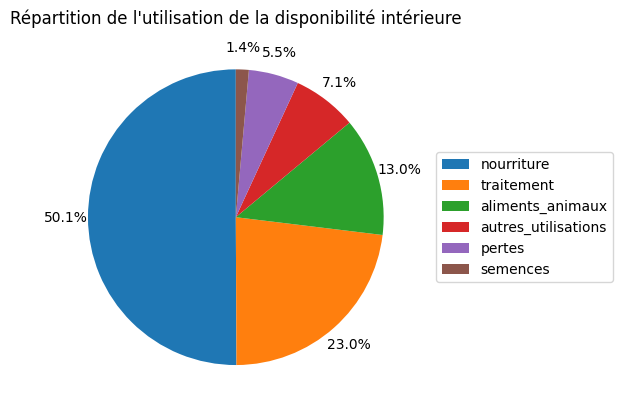

In [46]:
# Création DataFrame 'utilisation_disponibilite' et traçage graphique
utilisation_disponibilite = (disponibilite[['aliments_animaux', 'autres_utilisations', 'nourriture', 'pertes', 'semences', 'traitement']]
    .sum()
    .sort_values(ascending = False)
)
plt.pie(utilisation_disponibilite.values, autopct = '%.1f%%', pctdistance = 1.15, startangle = 90)
plt.title('Répartition de l\'utilisation de la disponibilité intérieure')
plt.legend(utilisation_disponibilite.index, loc = 7, bbox_to_anchor=(1.54, 0.5))
plt.show()

Seule la moitié de la disponibilité est utilisée, avec certitude, pour l'alimentation humaine alors que les pertes et les aliments pour animaux représentent presque **20 % du total**.<br>
Pour aller plus loin, faisons le même travail mais en ciblant dans un premier temps les produits d'origine végétale puis en zoomant spécifiquement sur les céréales.

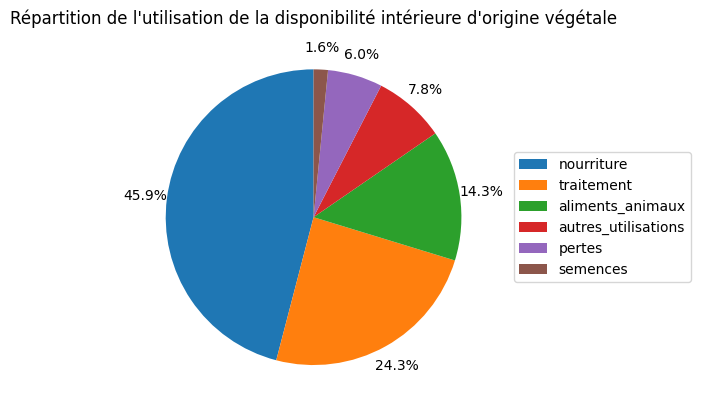

In [47]:
# Création DataFrame 'utilisation_disponibilite_vegetale' et traçage graphique
utilisation_disponibilite_vegetale = disponibilite.loc[
    disponibilite['origine'] == 'vegetale',
    ['aliments_animaux', 'autres_utilisations', 'nourriture', 'pertes', 'semences', 'traitement']
].sum().sort_values(ascending = False)

plt.pie(utilisation_disponibilite_vegetale.values, autopct = '%.1f%%', pctdistance = 1.15, startangle = 90)
plt.title('Répartition de l\'utilisation de la disponibilité intérieure d\'origine végétale')
plt.legend(utilisation_disponibilite_vegetale.index,  loc = 7, bbox_to_anchor=(1.54, 0.5))
plt.show()

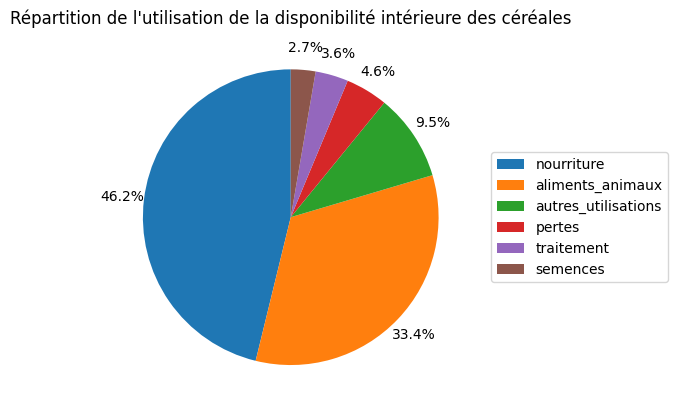

In [48]:
# Création DataFrame 'utilisation_disponibilite_cereales' et traçage graphique
utilisation_disponibilite_cereales = disponibilite.loc[
    disponibilite['produit'].isin(liste_cereales),
    ['aliments_animaux', 'autres_utilisations', 'nourriture', 'pertes', 'semences', 'traitement']
].sum().sort_values(ascending = False)

plt.pie(utilisation_disponibilite_cereales.values, autopct = '%.1f%%', pctdistance = 1.15, startangle = 90)
plt.title('Répartition de l\'utilisation de la disponibilité intérieure des céréales')
plt.legend(utilisation_disponibilite_cereales.index, loc = 7, bbox_to_anchor=(1.54, 0.5))
plt.show()

<a id="16"></a> 
## Demandes de Mélanie

Pour finir, nous allons travailler sur les demandes concernant les pays formulées par Mélanie, une chercheuse de l'équipe.

<a id="17"></a> 
### Pays avec la plus forte proportion de personnes sous-alimentées

Nous avons précédemment créé le *DataFrame* `population_sous_nutrition`. Il contient les informations nécessaires pour calculer le taux de sous nutrition par pays qui nous permettra ensuite de trier ces derniers.

In [49]:
# Calcul 'taux_sous_nutrition' et tri par pays
population_sous_nutrition['taux_sous_nutrition'] = (
    population_sous_nutrition['valeur_sous_nutrition'] / population_sous_nutrition['valeur_population']
)
population_sous_nutrition.nlargest(10, 'taux_sous_nutrition').style.format({'taux_sous_nutrition':'{:.1%}'})

,zone,valeur_population,valeur_sous_nutrition,taux_sous_nutrition
87,Haïti,10.982366,5.300000,48.3%
181,République populaire démocratique de Corée,25.429825,12.000000,47.2%
128,Madagascar,25.570512,10.500000,41.1%
122,Libéria,4.702226,1.800000,38.3%
119,Lesotho,2.091534,0.800000,38.2%
216,Tchad,15.016753,5.700000,38.0%
186,Rwanda,11.980961,4.200000,35.1%
145,Mozambique,28.649018,9.400000,32.8%
219,Timor-Leste,1.243258,0.400000,32.2%
0,Afghanistan,36.296113,10.500000,28.9%


<a id="18"></a> 
### Pays ayant le plus bénéficié d'aides depuis 2013

Grâce au jeu de données de l'aide alimentaire nous pouvons regrouper les aides par pays et calculer le montant total dont ils ont bénéficié depuis 2013.

In [50]:
# Calcul aides et tri descendant par pays
aide.groupby('zone')['valeur'].sum().nlargest(10)

zone
République arabe syrienne           1858943
Éthiopie                            1381294
Yémen                               1206484
Soudan du Sud                        695248
Soudan                               669784
Kenya                                552836
Bangladesh                           348188
Somalie                              292678
République démocratique du Congo     288502
Niger                                276344
Name: valeur, dtype: int64

Pour aller plus loin, essayons de voir de quels types de produits les pays ont le plus bénéficié.

In [51]:
# Calcul aides et tri descendant par produit
aide.groupby('produit')['valeur'].sum().nlargest(10)

produit
Céréales                    4256884
Blé et Farin                1781515
Non-céréales                1261513
Céréales Secondaires        1166565
Riz, total                   742418
Légumineuses Sèches,Tot.     737398
Mélanges et préparations     425839
Huiles végétales             344973
BulgurFarEnt                 140547
Sucre, total                 101014
Name: valeur, dtype: int64

Les céréales semblent avoir une place importante. A partir des résultats du top 10, voyons quelle part ils représentent exactement.

In [52]:
# Calcul proportion céréales dans aides
liste_cereales_aides = ['Céréales', 'Blé et Farin', 'Céréales Secondaires', 'Riz, total']
somme_cereales_aides = aide.loc[aide['produit'].isin(liste_cereales_aides), 'valeur'].sum()
part_cereales_aides = somme_cereales_aides / aide['valeur'].sum()
print('{:.1%}'.format(part_cereales_aides))

72.0%


<a id="19"></a> 
### Pays avec le plus et le moins de disponibilité par habitant

A partir du *DataFrame* `disponibilite_zone`, nous allons afficher les 10 pays avec la plus forte disponibilité puis ceux avec la moins forte. Nous faisons le choix de faire le tri sur les apports caloriques.

In [53]:
disponibilite_zone[['zone','disponibilite_kcal_p_j']].nlargest(10, 'disponibilite_kcal_p_j')

,zone,disponibilite_kcal_p_j
74,Irlande,3834
182,États-Unis d'Amérique,3774
17,Belgique,3771
170,Turquie,3734
11,Autriche,3685
75,Islande,3651
76,Israël,3562
132,Roumanie,3552
4,Allemagne,3545
55,France,3509


In [54]:
(disponibilite_zone.loc[disponibilite_zone['disponibilite_kcal_p_j'] != 0, ['zone','disponibilite_kcal_p_j']]
).nsmallest(10, 'disponibilite_kcal_p_j')

,zone,disponibilite_kcal_p_j
26,Burundi,1740
136,République centrafricaine,1903
94,Madagascar,1915
107,Mozambique,1928
176,Yémen,1991
119,Ouganda,2030
178,Zimbabwe,2045
142,République populaire démocratique de Corée,2090
82,Kenya,2144
67,Haïti,2145


En ce qui concerne les apports calorifiques, on constate que certain pays ont une disponibilité largement supérieure aux apports moyens nécessaires (2 250 kcal/p/j). Néanmoins,  le nombre de pays avec une disponibilités inférieure n'est pas si élevé que cela et la valeur minimale reste assez proche des apports nécessaires.

<a id="20"></a> 
## Conclusion

Nos calculs nous ont permis de constater, qu'en théorie, la disponibilité alimentaire permettrait de couvrir les besoins de l'ensemble de la population. Dans le détail, les produits d'origine végétale seraient suffisants, contrairement à ceux d'origine animale.<br>
A l'échelle des pays, là aussi la disponibilité théorique est suffisante pour une grande majorité d'entre eux, même si certains disposent de plus que nécessaire quand d'autres atteignent seulement 80 % des besoins moyens.<br>
Néanmoins, cela ne reflète pas la réalité qui montre que **près de 13 % de la population souffre de sous-nutrition**.<br><br>
Les chiffres soulèvent encore plus d'interrogations lorsque l'on étudie l'utilisation qui est faite de la disponibilité des produits.<br>
Les exportations représentent parfois pratiquement la totalité de la production de pays pourtant en sous-nutrition, comme dans notre exemple avec la Thaïlande.<br>
L'étude sur les céréales montrent que **38 % sont perdus ou servent à nourrir les animaux** alors que **72 % des aides fournies** aux pays en sous-nutrition le sont avec des céréales.<br><br>
On pourrait en conclure que l'élevage et la consommation de viande, qui profite seulement à une petite part de la population mondiale, nécessite une quantité de produits végétaux et surtout de céréales qui serait suffisante pour nourrir la plupart de la population en sous-nutrition.